# Forecasting Polish Inflation Rates (March 2024 Update)

Author: **Marcin Sikorski**<br>
Date: March, 2024

Update of univariate time series forecasting. The forecast will be performed with deep learning.

**Notebook Content:**
1. Reading Dataset
2. Preprocessing Data
3. Convolutional Neural Network (CNN)
4. Long Short-Term Memory (LSTM)
5. Out-Of Sample Predictions
6. Conclusion

### 1. Reading Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import data
def load_data():
    dataset = pd.read_excel('poland_inflation_ratings.xlsx')
    
    dataset = dataset.melt(id_vars='Year', var_name='Month', value_name='Rate') # unpivot from wide to long format
    
    from pandas.tseries.offsets import MonthEnd
    
    dataset['Date'] = pd.to_datetime(dataset[['Year', 'Month']].assign(DAY=1)) + MonthEnd(1) # assign last day of month
    
    dataset.sort_values(by='Date', ascending=True, inplace=True) # order ascending data values

    dataset.drop(['Year', 'Month'], axis=1, inplace=True) # drop unnecessary columns
    
    dataset.set_index('Date', inplace=True) # set date column as index

    dataset.dropna(subset=['Rate'], inplace=True) # drop NaN rows
    
    return dataset
    
df = load_data()
df.tail()

,Rate
Date,
2023-09-30,7.7
2023-10-31,6.3
2023-11-30,6.3
2023-12-31,6.2
2024-01-31,3.9


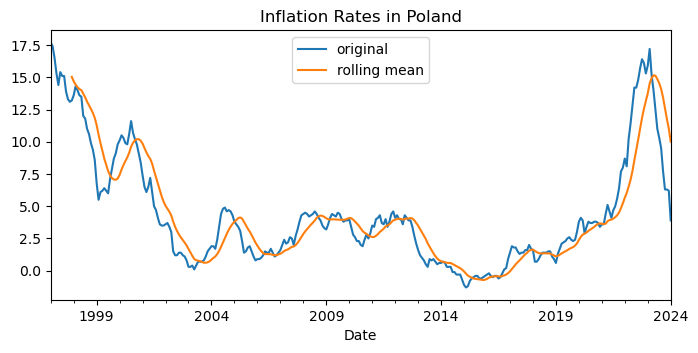

In [2]:
plt.figure(figsize=(8, 3.5))

df['Rate'].plot(label='original')
df['Rate'].rolling(window=12).mean().plot(label='rolling mean')
plt.title('Inflation Rates in Poland')
plt.legend()

plt.show()

### 2. Preprocessing Data

> The ADF test itself does not directly determine the optimum number of lags for a time series, it still can help in identifying the order of differencing required to make a time series stationary. This test still returns the number of lags used in correlation.

In [3]:
from statsmodels.tsa.stattools import adfuller

n_lags = adfuller(df['Rate'], autolag='AIC')[2]
print('Number of lags:', n_lags)

Number of lags: 13


In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

# reshape 1d array to 2d array - from (N,) to (N, 1)
dataset = np.reshape(df.values, (-1, 1))

# normalize dataset
norm_df = scaler.fit_transform(dataset)

print('Data shape:', norm_df.shape)

Data shape: (325, 1)


In [5]:
# supervised & target subsets
X, y = [], []

for i in range(n_lags, len(df)):
    X.append(norm_df[i - n_lags:i, 0])
    y.append(norm_df[i, 0])
    
# convert lists into arrays
X, y = np.array(X), np.array(y)

# reshape 2d array to 3d array (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
y = np.reshape(y, (y.shape[0], 1))

print('X shape :', X.shape)
print('y shape :', y.shape)

X shape : (312, 13, 1)
y shape : (312, 1)


### 3. Convolutional Neural Network (CNN)

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D

# define CNN model
cnn = Sequential()
cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X.shape[1], X.shape[2])))
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Flatten())
cnn.add(Dense(50, activation='relu'))
cnn.add(Dense(1))
cnn.compile(optimizer='adam', loss='mean_squared_error')

cnn_history = cnn.fit(
    x=X,
    y=y,
    epochs=200,
    batch_size=10,
    verbose=0,
    callbacks=None
)

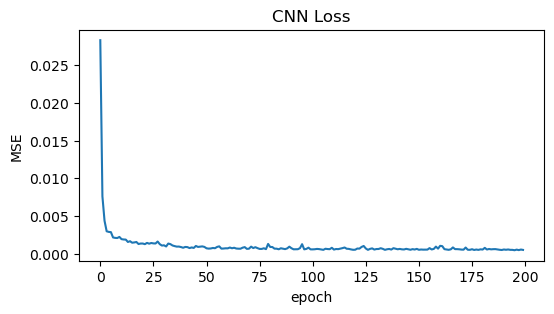

In [7]:
# plot learning process
plt.figure(figsize=(6, 3))

plt.plot(range(200), cnn_history.history['loss'])
plt.title('CNN Loss')
plt.xlabel('epoch')
plt.ylabel('MSE')

plt.show()

In [8]:
# make predictions and rescale back from [0, 1] to original
cnn_predictions = cnn.predict(X)
cnn_pred = scaler.inverse_transform(cnn_predictions)

# true inflation rates
true = df.iloc[n_lags:]

10/10 [==============================] - 0s 1ms/step


In [9]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

rmse = np.sqrt(mean_squared_error(true, cnn_pred))
r2 = r2_score(true, cnn_pred)
mae = mean_absolute_error(true, cnn_pred)
mape = mean_absolute_percentage_error(true, cnn_pred)

print('CNN performance:')
print('----------------')
print('RMSE: {:.4f}'.format(rmse))
print('R2: {:.4f}'.format(r2))
print('MAE: {:.4f}'.format(mae))
print('MAPE: {:.4f}%'.format(mape))

CNN performance:
----------------
RMSE: 0.4008
R2: 0.9892
MAE: 0.3012
MAPE: 0.1753%


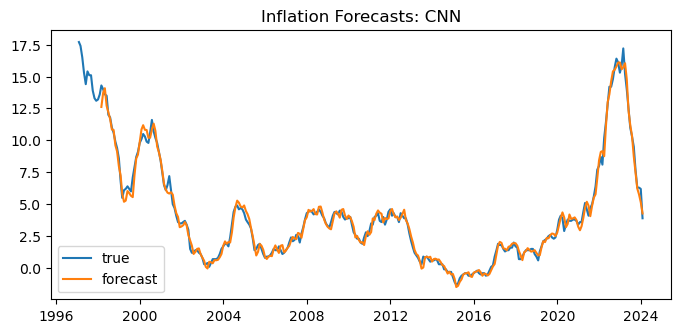

In [10]:
# plot predictions
plt.figure(figsize=(8, 3.5))

plt.plot(df['Rate'], label='true')
plt.plot(df.iloc[n_lags:].index, cnn_pred, label='forecast')
plt.title('Inflation Forecasts: CNN')
plt.legend()

plt.show()

In [11]:
# number of time steps (months) to forecast ahead
forecast_period = 6
forecast = []
last_sequence = X[-1]

# get out-of samples
for _ in range(forecast_period):
    last_sequence = last_sequence.reshape((1, n_lags, 1)) # reshape last_sequence for prediction
    
    next_pred = cnn.predict(last_sequence) # predict the next value
    
    forecast.append(next_pred[0, 0]) # append the predicted value to list
    
    # update last_sequence with the new value
    last_sequence = np.append(last_sequence[:, 1:, :], next_pred[0, 0]).reshape((1, n_lags, 1))

cnn_forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

1/1 [==============================] - 0s 25ms/step


### 4. Long Short-Term Memory (LSTM)

In [12]:
from keras.layers import LSTM

# define LSTM model
lstm = Sequential()
lstm.add(LSTM(units=64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
lstm.add(LSTM(units=64, return_sequences=False))
lstm.add(Dense(32))
lstm.add(Dense(1))
lstm.compile(optimizer='adam', loss='mean_squared_error')

lstm_history = lstm.fit(
    x=X,
    y=y,
    epochs=60,
    batch_size=10,
    verbose=0,
    callbacks=None
)

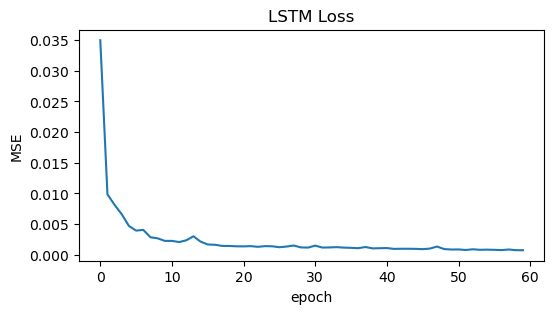

In [13]:
plt.figure(figsize=(6, 3))

plt.plot(range(60), lstm_history.history['loss'])
plt.title('LSTM Loss')
plt.xlabel('epoch')
plt.ylabel('MSE')

plt.show()

In [14]:
# make predictions and rescale back from [0, 1] to original
lstm_predictions = lstm.predict(X)
lstm_pred = scaler.inverse_transform(lstm_predictions)

10/10 [==============================] - 1s 5ms/step


In [15]:
rmse = np.sqrt(mean_squared_error(true, lstm_pred))
r2 = r2_score(true, lstm_pred)
mae = mean_absolute_error(true, lstm_pred)
mape = mean_absolute_percentage_error(true, lstm_pred)

print('LSTM performance:')
print('-----------------')
print('RMSE: {:.4f}'.format(rmse))
print('R2: {:.4f}'.format(r2))
print('MAE: {:.4f}'.format(mae))
print('MAPE: {:.4f}%'.format(mape))

LSTM performance:
-----------------
RMSE: 0.4957
R2: 0.9835
MAE: 0.3736
MAPE: 0.2218%


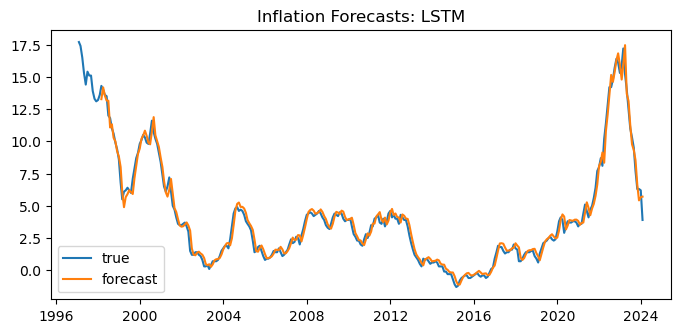

In [16]:
# plot predictions
plt.figure(figsize=(8, 3.5))

plt.plot(df['Rate'], label='true')
plt.plot(df.iloc[n_lags:].index, lstm_pred, label='forecast')
plt.title('Inflation Forecasts: LSTM')
plt.legend()

plt.show()

In [17]:
forecast = []
last_sequence = X[-1]

# get out-of samples
for _ in range(forecast_period):
    last_sequence = last_sequence.reshape((1, n_lags, 1)) # reshape last_sequence for prediction
    
    next_pred = lstm.predict(last_sequence) # predict the next value
    
    forecast.append(next_pred[0, 0]) # append the predicted value to list
    
    # update last_sequence with the new value
    last_sequence = np.append(last_sequence[:, 1:, :], next_pred[0, 0]).reshape((1, n_lags, 1))

lstm_forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

1/1 [==============================] - 0s 22ms/step


### 5. Out-Of Sample Predictions

In [18]:
# mm/dd/yyyy format
placeholder = pd.date_range(start='02/01/2024', end='08/01/2024', freq='M')

# new dataframe with out-of samples
df_forecasts = pd.DataFrame()
df_forecasts['date'] = placeholder
df_forecasts['cnn'] = cnn_forecast
df_forecasts['lstm'] = lstm_forecast
df_forecasts.set_index('date', inplace=True)

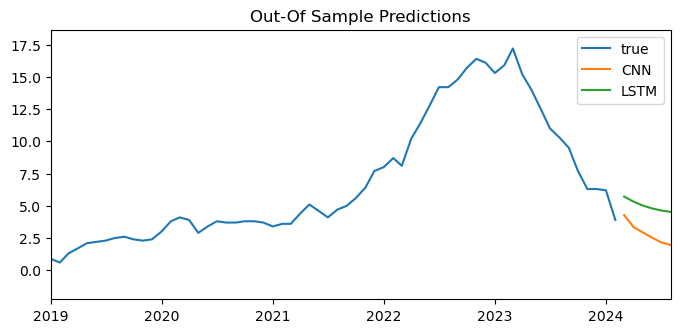

In [19]:
# plot out-of samples
plt.figure(figsize=(8, 3.5))

plt.plot(df['Rate'], label='true')
plt.plot(df_forecasts['cnn'], label='CNN')
plt.plot(df_forecasts['lstm'], label='LSTM')
plt.title('Out-Of Sample Predictions')
plt.xlim(pd.Timestamp('2019-01-01'), df_forecasts.index[-1])
plt.legend()

plt.show()

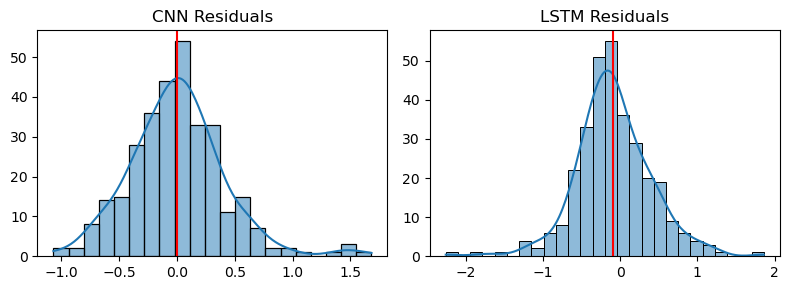

In [20]:
from seaborn import histplot

# residuals
cnn_resid = true.values - cnn_pred
lstm_resid = true.values - lstm_pred

plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
histplot(x=cnn_resid.reshape(-1,), kde=True)
plt.axvline(x=cnn_resid.mean(), color='red') # plot mean value
plt.title('CNN Residuals')
plt.xlabel(None)
plt.ylabel(None)

plt.subplot(1, 2, 2)
histplot(x=lstm_resid.reshape(-1,), kde=True)
plt.axvline(x=lstm_resid.mean(), color='red') # plot mean value
plt.title('LSTM Residuals')
plt.xlabel(None)
plt.ylabel(None)

plt.tight_layout()
plt.show()

|          | RMSE   | R<sup>2 | MAE    | MAPE [%] |
|----------|--------|---------|--------|----------|
| **CNN**  | 0.4008 | 0.9892  | 0.3012 | 0.1753   |
| **LSTM** | 0.4957 | 0.9835  | 0.3736 | 0.2218   |
    
### 6. Conclusion
    
We forecasted inflation rates with deep learning for the nearest six month time period. Polish inflation will continue to decrease in the nearest months. Two neural networks were developed to extract out-of sample predictions. Based on evaluation metrics and model residuals, the CNN (convolutional neural network) performed better and is less biased.